In [2]:
import ccxt
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pytz
from collections import OrderedDict


plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')


In [17]:
binance = ccxt.binance()
coin = 'BTC/USDT'
timeframe = '1d'
limit = 1000
data = binance.fetch_ohlcv(coin, timeframe, limit = limit)
df = pd.DataFrame(data, columns=['timestamp', 'open','high','low','close','volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')


In [18]:
df.head()

timestamp     open     high      low    close        volume
0 2020-07-09  9436.06  9440.79  9160.00  9232.43  48044.450645
1 2020-07-10  9232.42  9317.48  9125.00  9288.34  38295.494006
2 2020-07-11  9288.34  9299.28  9178.25  9234.03  22561.366000
3 2020-07-12  9234.02  9345.00  9157.50  9302.75  30872.702286
4 2020-07-13  9303.31  9343.82  9200.89  9242.62  42740.069115

In [19]:
df.tail()

timestamp      open      high       low     close       volume
995 2023-03-31  28028.53  28656.69  27511.71  28465.36  78198.12139
996 2023-04-01  28465.36  28819.71  28220.27  28452.73  30238.44753
997 2023-04-02  28452.74  28530.00  27856.43  28171.87  37365.65692
998 2023-04-03  28171.87  28500.99  27200.24  27800.00  79180.01405
999 2023-04-04  27800.00  28145.00  27662.79  28106.18  16372.51229

In [13]:
df.to_csv('BTC.csv')

In [12]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

df_macd = get_macd(df['close'], 26, 12, 9)
df_macd.tail()

df = pd.concat([df, df_macd], join = 'inner', axis =1)

In [13]:
df.to_csv(f'btc_ohlv_macd.csv')

In [14]:
def plot_macd(prices, macd, signal, hist):
    plt.figure(figsize = (12,8))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan=3, colspan=1, sharex=ax1)
    
    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', lw = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'blue', lw = 1.5, label = 'Signal')
    
    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')
    plt.legend(loc = 'lower right')
    plt.tight_layout()
    plt.show()    

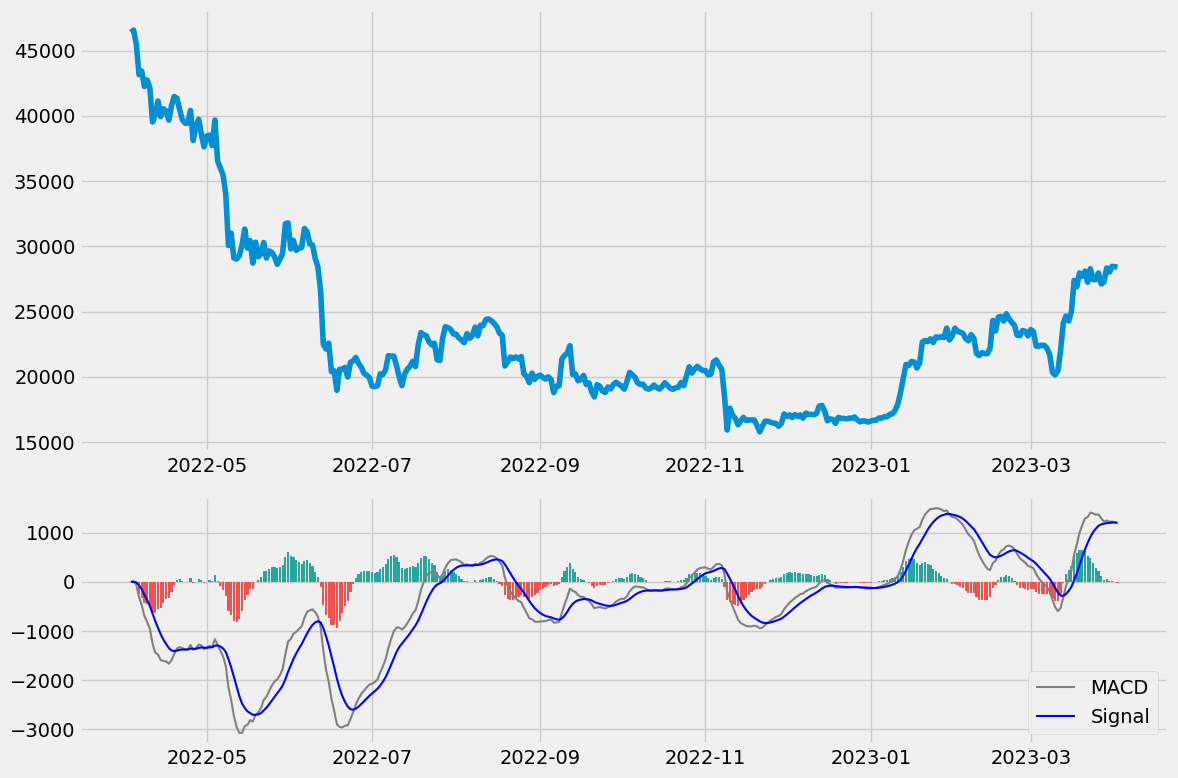

In [15]:
plot_macd(df['close'], df['macd'], df['signal'], df['hist'])

In [16]:
def implement_macd_strategy(prices, data):
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
    
    return buy_price, sell_price, macd_signal

        
            

In [17]:
buy_price, sell_price, maxd_signal = implement_macd_strategy(df['close'], df_macd)

In [18]:
buy = pd.DataFrame(buy_price, columns = ['buy_price'])
sell = pd.DataFrame(sell_price, columns = ['sell_price'])
buy.dropna(inplace= True)
sell.dropna(inplace= True)

In [19]:
sum_buy = buy.sum()
sum_sell = sell.sum()
print(sum_buy[0])
print(sum_sell[0])
profit = sum_sell[0] - sum_buy[0]
print(f'Profit: {profit}')

419046.72000000003
413728.51
Profit: -5318.210000000021
